# Biquadratic Coupling Demo 1

Example taken from Ubermag 
https://ubermag.github.io/examples/notebooks/rkky.html

But I reduced the M_sat of a layer by a half to better demonstrate the effect of the exchange coupling. 


In [2]:
from magnumnp import *
import torch
import numpy as np
from tqdm import tqdm

torch.set_default_dtype(torch.float32)

2024-04-03 18:33:41  magnum.np:WARNING module 'torch' has no attribute 'compile'
2024-04-03 18:33:41  magnum.np:INFO magnum.np 1.1.5


In [3]:
sigma2 = 2. * np.array([0, -0.1, -0.05, -0.01])

for J_rkky in sigma2:
        Timer.reset()
        Timer.enable()
        
        # initialize mesh
        dt = 1e-10
        n  = (20, 20, 5)
        dx = (3e-9, 3e-9, 2e-9)
        mesh = Mesh(n, dx)
        state = State(mesh)

        # set domain and materials
        domain1 = state.zeros(n, dtype=torch.bool)
        domain2 = state.zeros(n, dtype=torch.bool)
        domain1[:,:,0:2] = True
        domain2[:,:,3:5] = True
        
        state.material = {
                "A": 1e-12,
                "Ku": 1e5,
                "Ku_axis": [1, 0, 0],
                "alpha": 1,
                }

        state.material['Ms'] = state.Constant(0.0)
        state.material['Ms'][domain1] = 8e6
        state.material['Ms'][domain2] = 4e6

        # set initial magnetization
        #size_ref = state.m[domain1].shape

        state.m = state.Constant([0, 0, 0])
        state.m[domain1] = state.Tensor([-0.99, 0.01, 0])
        state.m[domain2] = state.Tensor([0.99, 0.01, 0])

        # define field terms
        exchange1 = ExchangeField(domain1)
        exchange2 = ExchangeField(domain2)
        rkky      = BiquadraticRKKYField(J_rkky, "z", 1, 3)
        aniso     = UniaxialAnisotropyField()
        demag     = DemagField()

        set_log_level(100)
        llg = LLGSolver([demag, exchange1, exchange2, aniso, rkky])
        llg.relax(state)
        
        external = ExternalField(TimeInterpolator(state, { 0.0e-9: [0.0, 0.0, 0.0],
                                                           1.0e-9: [0.0, 0.0, 0.0],
                                                           3.5e-9: [0.0, 0.0, 20/constants.mu_0],
                                                           8.5e-9: [0.0, 0.0, -20/constants.mu_0],
                                                          13.5e-9: [0.0, 0.0, 20/constants.mu_0]}))

        llg = LLGSolver([demag, aniso, exchange1, exchange2, external, rkky])
        M = lambda state: state.m * state.material['Ms'] / state.material['Ms'].avg()
        logger = ScalarLogger(f"data/log_{J_rkky}.dat", ['t', external.h, 'm', ('M', M)])
        
        for i in tqdm(np.arange(0, 13.5e-9, dt)):
            llg.step(state, dt)
            logger << state

        set_log_level(30)
        Timer.print_report()

/home/florian/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
2024-04-03 14:26:05  magnum.np:INFO [State] running on device: cpu (dtype = float32)
2024-04-03 14:26:05  magnum.np:INFO [Mesh] 20x20x5 (size= 3e-09 x 3e-09 x 2e-09)
100%|██████████| 135/135 [03:33<00:00,  1.58s/it]



TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                            1     15961.5             15.9615
    DemagField.h                        3934         1.60559          6.31639
    ExchangeField.h                     7868         0.704487         5.5429
    UniaxialAnisotropyField.h           3934         0.232732         0.915569
    BiquadraticRKKYField.h              3804         0.288265         1.09656
LLGSolver.step                           135      1576.93           212.885
    DemagField.h                       39594         1.86063         73.6698
    UniaxialAnisotropyField.h          39594         0.298135        11.8044
    ExchangeField.h                    79188         0.916249        72.5559
    ExternalField.h                    39594         0.148762         5.89007
    BiquadraticRKKYField.h             39594        

100%|██████████| 135/135 [16:24<00:00,  7.29s/it]



TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                            1    124628              124.628
    DemagField.h                       24087         1.91833         46.2067
    ExchangeField.h                    48174         0.938869        45.2291
    UniaxialAnisotropyField.h          24087         0.307354         7.40324
    BiquadraticRKKYField.h             23916         0.381681         9.12829
LLGSolver.step                           135      7290.15           984.17
    DemagField.h                      180174         1.88284        339.239
    UniaxialAnisotropyField.h         180174         0.30286         54.5676
    ExchangeField.h                   360348         0.935272       337.023
    ExternalField.h                   180174         0.148688        26.7897
    BiquadraticRKKYField.h            180174         0.3928

100%|██████████| 135/135 [08:20<00:00,  3.71s/it]



TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                            1    109496              109.496
    DemagField.h                       21225         1.91673         40.6826
    ExchangeField.h                    42450         0.935825        39.7258
    UniaxialAnisotropyField.h          21225         0.306485         6.50515
    BiquadraticRKKYField.h             20958         0.380868         7.98222
LLGSolver.step                           135      3706.45           500.371
    DemagField.h                       91530         1.8851         172.543
    UniaxialAnisotropyField.h          91530         0.302976        27.7314
    ExchangeField.h                   183060         0.938329       171.771
    ExternalField.h                    91530         0.149124        13.6493
    BiquadraticRKKYField.h             91530         0.392

100%|██████████| 135/135 [03:49<00:00,  1.70s/it]


TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                            1     27418.4             27.4184
    DemagField.h                        5233         2.01974         10.5693
    ExchangeField.h                    10466         0.931881         9.75307
    UniaxialAnisotropyField.h           5233         0.304305         1.59243
    BiquadraticRKKYField.h              5076         0.377233         1.91483
LLGSolver.step                           135      1700.43           229.558
    DemagField.h                       41646         1.90194         79.2081
    UniaxialAnisotropyField.h          41646         0.305705        12.7314
    ExchangeField.h                    83292         0.945038        78.7141
    ExternalField.h                    41646         0.150316         6.26005
    BiquadraticRKKYField.h             41646         

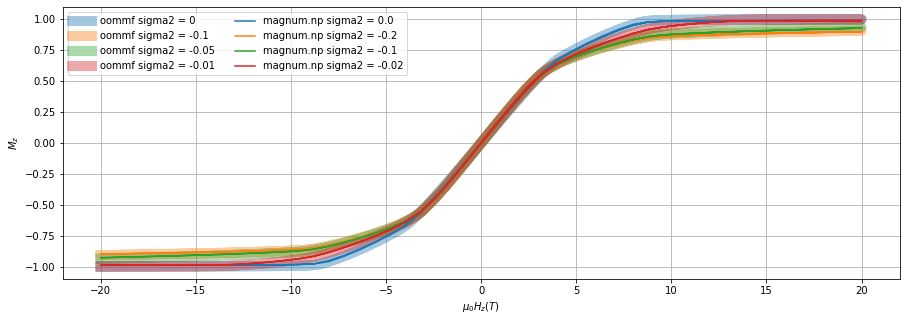

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

sigma2_oommf = [0, -0.1, -0.05, -0.01]
for i, sigma2 in enumerate(sigma2_oommf):
    B_oommf = np.load(f"ref/oommf_hysteresis_Bz_sigma2_{sigma2}.npy")/1000
    M_oommf = np.load(f"ref/oommf_hysteresis_mz_sigma2_{sigma2}.npy")

    ax.plot(B_oommf, M_oommf, alpha = 0.4,label = f"oommf sigma2 = {sigma2}", color = cycle[i], linewidth = 10)

sigma2 = 2. * np.array([0, -0.1, -0.05, -0.01])
for i, J_rkky in enumerate(sigma2):
    data = np.loadtxt(f"data/log_{J_rkky}.dat")
    B = data[:,3]*4*np.pi*1e-7
    M = data[:,9]
        
    ax.plot(B, M, label = f"magnum.np sigma2 = {sigma2[i]}", color = cycle[i])

ax.set_xlabel("$\mu_0 H_z [T]$")
ax.set_ylabel("$M_z$")
ax.legend(ncol = 2)
ax.grid()